Hao Wu  July 18 2020 <br />
This code is intended to generate training data for our model

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pathlib
from tqdm.notebook import tqdm
import pandas as pd
import itertools
import statistics

# 1. Preparation

## 1.1 Read & Check Distance Matrices

In [2]:
maps = os.listdir("contact_maps/")
pred = os.listdir("contact_predictions/")
maps_code = [m.split("_")[0] for m in maps]
pred_code = [p.split("_")[0] for p in pred]
# check duplicated elements in maps or preds
print (len(set(maps_code)) == len(maps_code))
print (len(set(pred_code)) == len(pred_code))

# check whether maps & preds match
print (set(maps_code) == set(pred_code)) # True, which means we have same set of acid code for real contact map and predictions
num_of_code = len(set(maps_code))
print (num_of_code) # number of acid codes/contact maps we are analyzing 


True
True
True
11181


## 1.2 Generate Square Diff Matrices 

1. For each pair of contact map & prediction, calculate squared difference between corresponding points of the two matrices and generate a square diff matrix.
2. Collect all data points in the upper triangular part of each sqr-diff matrix and store in a list
* upper triangular part: since data points on each contact map are symmetric about y=x, we can either focus on upper triangular part of the matrix (y>=x) or on lower triangular part (x>=y)

In [3]:
sqr_diff = {}
contact_pred = {}
diff_ele = []
for c in tqdm(maps_code):
    temp_map = np.load("contact_maps/"+c+"_contact_map.npy")
    temp_pred = np.load("contact_predictions/"+c+"_contact_pred.npy")
    temp = np.power(np.subtract(temp_map, temp_pred),2)
    size = temp.shape[0]
    contact_pred[c] = (temp_pred, size)
    sqr_diff[c] = (temp, size)
    iu = np.triu_indices(size) # indices in upper triangle matrix
    
    # concatenating flatten np matrix with list is faster than merging np matrix
    diff_ele += list(temp[iu].flat) 


## 1.3 Hyperparameters

There are two hyperparameters:
1. cutoff of sqr-diff value
2. neighbor range

### Choose Cutoff of Squared Difference Value 

1. The cutoff serves to determine whether a squared difference value is large enough so that the corresponding data point in predicted contact map can be considered as an error.
2. Based on the list of all sqr-diff data points, we can choose a cutoff according to its distribution.
3. Here I have chosen 75% quantile of all the sqr-diff data.

In [4]:
print (len(sqr_diff))
print (len(diff_ele)) # 736777153 | 369656525

# takes about 5-6 | 2-3 min to compute
#cutoff = np.quantile(diff_ele,0.75) # 7.172270573359031e-06 | 7.068872962487293e-06
cutoff = 7.068872962487293e-06
#print (cutoff)

11181
369656525


### Neighbor Range & Get Neighbors Function

Neighbor range determines the size of region we are going to check around certain data point. 
For example, for a data point (i,j), given neighbor range n = 1, the neighbor we are going to check will be (i-1,j-1), (i,j-1), (i+1,j-1), (i-1,j), (i+1,j), (i-1,j+1), (i,j+1), (i+1,j) 

In [5]:
nb_range = 3 # one of the two hyperparameters

In [6]:
def get_neighbors(x,y,n,s,matrix):
    
    perm = list(itertools.product(list(range(max(x-n,0),min(x+n+1,s))),list(range(max(y-n,0),min(y+n+1,s)))))
    perm.remove((x,y))
    #half_perm_values = [matrix[p[0]][p[1]] for p in perm]
    half_perm_values = [matrix[p[0]][p[1]] for p in perm if p[0]<=p[1]]
    
    '''
    neighbor_matrix = matrix[max(x-n,0):min(x+n+1,s), max(y-n,0):min(y+n+1,s)]
    iu_neighbor_matrix = np.triu_indices(neighbor_matrix.shape[0])
    half_perm_values = list(neighbor_matrix[iu_neighbor_matrix].flat)
    half_perm_values.remove(matrix[x][y])
    '''
    return (min(half_perm_values),statistics.median(half_perm_values),max(half_perm_values),statistics.mean(half_perm_values),statistics.stdev(half_perm_values))


# 2. Generate Training Data

The training data will be in form of feature values + output value. Each row of entries corresponds to a point in the predicted contact map, and includes features about 
1. predicted value 
2. information about adjacent points (min, med, max, mean, sd)

The output value of each row is either 1 or 0. For each point in the predicted contact map, classify whether the data point is an error based on its value in sqr-diff matrix and cutoff value. If the sqr-diff is larger than cutoff, it will be classified as "TRUE" (output value 1), which means it is large enough to be considered as an error. On the contrary, if the sqr-diff is less than cutoff, it will be classified as "FALSE" (output value 0), which means it's not considered an error.

### Get Feature Values

In [7]:
# This is my original method to get feature values, which follows two steps:
# 1. Classify points into true/false points based on cutoff value
# 2. For each true/false points, get (1) predicted values in predicted contact map and (2) info about neighbor points
# 
# Since this method checks all of the 369656525 points, it bears with the issue of LONG runtime. 

def method_one():
    pred_value_true = []
    neighbor_value_true = []

    pred_value_false = []
    neighbor_value_false = []

    # takes more than 24 hours to compute
    for m in tqdm(maps_code):
        il = np.tril_indices(sqr_diff[m][1], -1) # index of lower triangle matrix without diagonal
        # change values in the lower triangular part to an arbitrary large number so that they won't be included in our training data
        sqr_diff[m][0][il] = 1000000  

        # --- True Data Points ---
        temp_result_true = np.where((sqr_diff[m][0]>=cutoff) & (sqr_diff[m][0]<1000000))

        # get predicted value at (x,y) of predicted contact map m
        pred_value_true += [contact_pred[m][0][temp_result_true[0][i]][temp_result_true[1][i]] for i in range(len(temp_result_true[0]))]
        # TO DO: get predicted value of points adjacent to (x,y) of predicted contact map m
        neighbor_value_true += [get_neighbors(temp_result_true[0][i],temp_result_true[1][i],nb_range,sqr_diff[m][1],contact_pred[m][0]) for i in range(len(temp_result_true[0]))]

        # --- False Data Points ---
        temp_result_false = np.where(sqr_diff[m][0]<cutoff)

        # get predicted value at (x,y) of predicted contact map m
        pred_value_false += [contact_pred[m][0][temp_result_false[0][i]][temp_result_false[1][i]] for i in range(len(temp_result_false[0]))]
        # TO DO: get predicted value of points adjacent to (x,y) of predicted contact map m
        neighbor_value_false += [get_neighbors(temp_result_false[0][i],temp_result_false[1][i],nb_range,sqr_diff[m][1],contact_pred[m][0]) for i in range(len(temp_result_false[0]))]
    
    return (pred_value_true,neighbor_value_true, pred_value_false, neighbor_value_false)
    

In [8]:
# This is the second method to get training data, based on our discussion, which follows two steps:
# 1. Select points we want to check.
# 2. For each points, get feature values as well as output value.
#    (1) predicted values in predicted contact map 
#    (2) info about neighbor points
#    (3) squared difference value, based on which we will ultimately assign 1 or 0 to each entry as output value
# 
# Depending on the value of neighbor range we choose, this method can check 1/49 ~ 1/9 of the 369656525 points, 
# shortening the final runtime to 3 hours (with neighbor range as 3). 

def method_two():
    pred_value = []
    neighbor_value = []
    sqr_diff_value = []
    
    for m in tqdm(maps_code):
        points_ind = list(itertools.product(list(range(0,sqr_diff[m][1],nb_range+1)),list(range(0,sqr_diff[m][1],nb_range+1))))
        
        pred_value += [contact_pred[m][0][p[0]][p[1]] for p in points_ind if p[0]<=p[1]]
        neighbor_value += [get_neighbors(p[0],p[1],nb_range,sqr_diff[m][1],contact_pred[m][0]) for p in points_ind if p[0]<=p[1]]
        sqr_diff_value += [sqr_diff[m][0][p[0]][p[1]] for p in points_ind if p[0]<=p[1]]
    
    return(pred_value, neighbor_value, sqr_diff_value)

### Output as .csv

Merge and convert lists to dataframe, and output as csv files.

In [9]:
'''
print (len(pos_true)) # 9214132
print (len(pos_false)) # 277242393
# 9214132 + 277242393 = 369656525, which echoes the number of all data points

# convert list to dataframe
data_true = pd.DataFrame(pos_true,columns=["pos_x", "pos_y"])
data_false = pd.DataFrame(pos_false,columns=["pos_x", "pos_y"])
data_true["output"] = 1 # TRUE data is marked 1
data_false["output"] = 0 # FALSE data is marked 0
print (data_true)
print (data_false)
'''
pred_value, neighbor_value, sqr_diff_value = method_two()


In [10]:
# output dataframes of training data to csv files
df_pred = pd.DataFrame(pred_value, columns = ["pred"])
df_neighbor = pd.DataFrame(neighbor_value, columns=["neighbor_min", "neighbor_med", "neighbor_max", "neighbor_mean", "neighbor_sd"])
training_data = pd.concat([df_pred, df_neighbor], axis=1)
training_data["sqr_diff"] = sqr_diff_value
training_data.to_csv("training_data.csv", index=False)


In [11]:
print (training_data)
print (len(pred_value))

                  pred  neighbor_min  neighbor_med  neighbor_max  \
0         1.000000e+00  3.448735e-01      0.999999      1.000000   
1         2.303483e-01  1.373577e-02      0.356021      1.000000   
2         1.214818e-02  5.842320e-03      0.022058      0.806485   
3         7.544638e-03  5.842320e-03      0.010829      0.024479   
4         9.081059e-03  8.041023e-03      0.011586      0.017962   
...                ...           ...           ...           ...   
23585333  1.923477e-03  2.356266e-07      0.000063      1.000000   
23585334  8.860329e-07  2.356266e-07      0.000010      0.949198   
23585335  1.000000e+00  9.134875e-06      0.974640      1.000000   
23585336  1.729165e-04  1.150460e-06      0.001329      1.000000   
23585337  1.000000e+00  1.915087e-03      0.999998      1.000000   

          neighbor_mean  neighbor_sd      sqr_diff  
0              0.887225     0.217816  6.646194e-16  
1              0.502149     0.419060  5.923637e-01  
2              0.077199 

# Visualize Contact Maps

not relevant to getting training data but may be referenced later

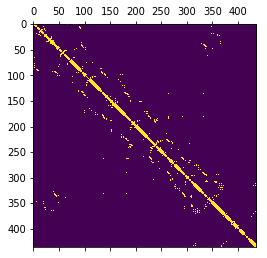

In [12]:
viz_cm = np.load("contact_maps/1A0CA_contact_map.npy")
plt.matshow(viz_cm)
plt.show()

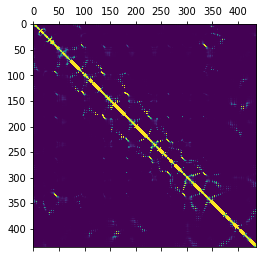

In [13]:
viz_cp = np.load("contact_predictions/1A0CA_contact_pred.npy")
plt.matshow(viz_cp)
plt.show()

In [14]:
def temp_func():
    return (1,2)


In [15]:
t_t = [temp_func() for i in range(3)]
print (t_t)
t_t_a = [1,2,3]
t_t_b = [4,5,6]
t_t_d = pd.DataFrame()
t_t_d["a"] = t_t_a
print (t_t_d)
t_t_d["b"] = t_t_b
print (t_t_d)
t_t_e = pd.DataFrame(t_t,columns=["ta","tb"])
print (t_t_e)
t_t_r = pd.concat([t_t_d, t_t_e], axis=1)
print (t_t_r)

[(1, 2), (1, 2), (1, 2)]
   a
0  1
1  2
2  3
   a  b
0  1  4
1  2  5
2  3  6
   ta  tb
0   1   2
1   1   2
2   1   2
   a  b  ta  tb
0  1  4   1   2
1  2  5   1   2
2  3  6   1   2
